In [1]:
%load_ext watermark
%watermark

2020-09-10T11:32:37-05:00

CPython 3.7.6
IPython 7.13.0

compiler   : GCC 7.3.0
system     : Linux
release    : 5.4.0-47-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit


In [2]:
import numpy as np

from sklearn.linear_model import LinearRegression as lr
from sklearn import datasets
from sklearn import metrics

In [3]:
boston = datasets.load_boston()

In [4]:
def rmse(objetivo, estimaciones):
    return np.sqrt(metrics.mean_squared_error(objetivo, estimaciones))

def adjusted_r2(objetivo, estimaciones, n, k):
    r2 = metrics.r2_score(objetivo, estimaciones)
    return 1 - ((1-r2)*(n-1)) / (n-k-1)

def evaluar_modelo(objetivo, estimaciones, n ,k):
    return {
        "RMSE" : rmse(objetivo, estimaciones),
        "MAE" : metrics.mean_absolute_error(objetivo, estimaciones),
        "adjusted_r2" : adjusted_r2(objetivo, estimaciones, n, k)
    }

In [5]:
modelo_ols = lr()

In [6]:
modelo_ols.fit(X=boston["data"], y=boston["target"])
modelo_ols_preds = modelo_ols.predict(boston["data"])

In [7]:
Resultados = {}

In [8]:
N = boston["data"].shape[0]

Resultados["ols"] = evaluar_modelo(
    boston["target"],
    modelo_ols_preds,
    N,
    len(modelo_ols.coef_)
)

Resultados

{'ols': {'RMSE': 4.679191295697281,
  'MAE': 3.2708628109003137,
  'adjusted_r2': 0.733789726372463}}

Este modelo tiene el problema de que al entrenar con todos los datos podria no generalizar de manera correcta y por tanto es posible que la complejidad sea muy alta.

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
train_test_split?

In [11]:
boston["data"].shape

(506, 13)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    boston["data"], boston["target"], test_size=0.33,
    random_state=13
)

In [13]:
print(X_train.shape, y_train.shape)

(339, 13) (339,)


In [14]:
print(X_test.shape, y_test.shape)

(167, 13) (167,)


In [15]:
modelo_ols = lr()

In [16]:
modelo_ols.fit(X=X_train, y=y_train)
modelo_ols_train_preds = modelo_ols.predict(X_train)


In [17]:
Resultados["ols_train"] = evaluar_modelo(
    y_train,
    modelo_ols_train_preds,
    X_train.shape[0],
    len(modelo_ols.coef_)
)
Resultados

{'ols': {'RMSE': 4.679191295697281,
  'MAE': 3.2708628109003137,
  'adjusted_r2': 0.733789726372463},
 'ols_train': {'RMSE': 4.7217324545168475,
  'MAE': 3.30086799221536,
  'adjusted_r2': 0.7314907015939042}}

In [18]:
modelo_ols_test_preds = modelo_ols.predict(X_test)

Resultados["ols_test"] = evaluar_modelo(
    y_test,
    modelo_ols_test_preds,
    X_test.shape[0],
    len(modelo_ols.coef_)
)
Resultados

{'ols': {'RMSE': 4.679191295697281,
  'MAE': 3.2708628109003137,
  'adjusted_r2': 0.733789726372463},
 'ols_train': {'RMSE': 4.7217324545168475,
  'MAE': 3.30086799221536,
  'adjusted_r2': 0.7314907015939042},
 'ols_test': {'RMSE': 4.784178251750706,
  'MAE': 3.558433720909835,
  'adjusted_r2': 0.6887158654171607}}

In [19]:
import pandas as pd
boston_df = pd.DataFrame(Resultados)
boston_df

,ols,ols_train,ols_test
RMSE,4.679191,4.721732,4.784178
MAE,3.270863,3.300868,3.558434
adjusted_r2,0.733790,0.731491,0.688716


Al evaluar los datos se obtiene un error mayor en los datos de test.

Pero esto depende del random state elegido y de que la partición que le hagamos al dataset sea una particpación representativa de los datos.

In [21]:
Resultados = {}

X_train, X_test, y_train, y_test = train_test_split(
    boston["data"], boston["target"], test_size=0.33,
    random_state=42
)

modelo_ols = lr()
modelo_ols.fit(X=X_train, y=y_train)
modelo_ols_train_preds = modelo_ols.predict(X_train)
modelo_ols_test_preds = modelo_ols.predict(X_test)

Resultados["ols_train"] = evaluar_modelo(
    y_train,
    modelo_ols_train_preds,
    X_train.shape[0],
    len(modelo_ols.coef_)
)

Resultados["ols_test"] = evaluar_modelo(
    y_test,
    modelo_ols_test_preds,
    X_test.shape[0],
    len(modelo_ols.coef_)
)

pd.DataFrame(Resultados)

,ols_train,ols_test
RMSE,4.794269,4.552365
MAE,3.376419,3.148256
adjusted_r2,0.728804,0.702889


Se evidencia que con ese *random_state* los modelos dependen de la partición que hagamos y del valor que definamos para este. 

In [30]:
modelo = lr()
results = []
def test_semilla(semilla):
    X_train, X_test, y_train, y_test = train_test_split(
        boston["data"], boston["target"],
        test_size=0.33, random_state=semilla
    )
    test_preds = modelo.fit(X=X_train,y=y_train).predict(X_test)
    error_semilla = rmse(y_test,test_preds)
    results.append([error_semilla, semilla])

In [31]:
for i in range(1000):
    test_semilla(i)

In [32]:
results[:5]

[[5.153501900847686, 0],
 [4.54955775262658, 1],
 [4.817966577147622, 2],
 [4.822833248024297, 3],
 [5.559184699608027, 4]]

In [33]:
resultados = sorted(results, key=lambda x: x[0], reverse=False)

In [34]:
resultados[0]

[3.631314217076958, 635]

In [36]:
resultados[-1]

[6.788054714003138, 645]

La variación del error es muy grande de acuerdo al *random_state* por tanto debemos utilizar validación cruzada

### Validación cruzada (cross_validation)

In [39]:
from sklearn.model_selection import cross_val_score

In [40]:
modelo = lr()
X = boston["data"]
y = boston["target"]

resultados_validacion_cruzada = cross_val_score(
    estimator = modelo_ols,
    X=X, #variables independientes
    y=y, #variables dependientes
    scoring="neg_mean_squared_error", #metodo de evaluación
    cv=10 #número de particiones 
)

In [41]:
resultados_validacion_cruzada

array([  -9.28694671,  -14.15128316,  -14.07360615,  -35.20692433,
        -31.88511666,  -19.83587796,   -9.94726918, -168.37537954,
        -33.32974507,  -10.96041068])

In [43]:
resultados_validacion_cruzada.mean()

-34.705255944525184

También podemos definir nuestra propia función para el metodo de evaluación, esta debe recibir tres parametros **estimador, X, y**

In [44]:
def rmse_cross_val(estimator,X,y):
    y_pred = estimator.predict(X)
    return np.sqrt(metrics.mean_squared_error(y, y_pred))

In [46]:
resultados_cv = []
for i in range(10,50):
    cv_rmse = cross_val_score(
        estimator=modelo,
        X=X,
        y=y,
        scoring=rmse_cross_val,
        cv=i
    ).mean()
    resultados_cv.append(cv_rmse)

In [47]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,12)

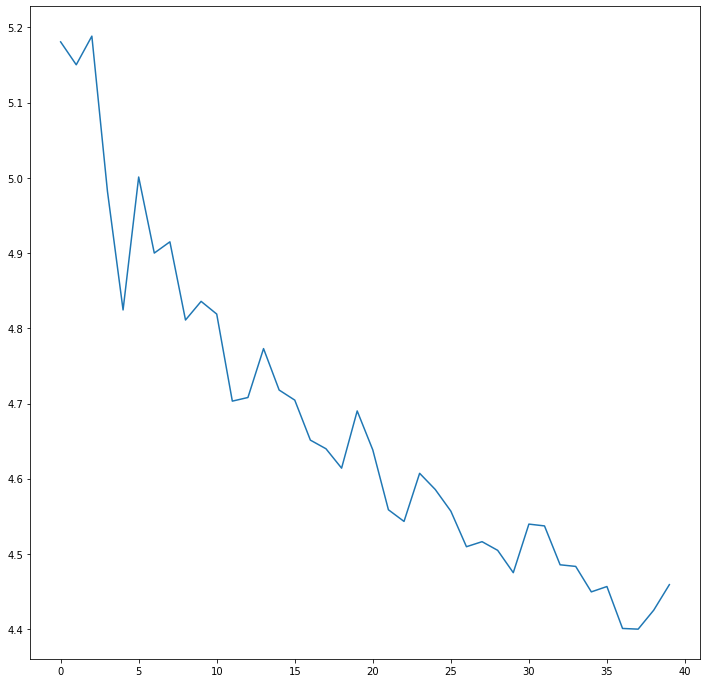

In [48]:
plt.plot(resultados_cv)

### croos_validate (otra forma de hacer validación cruzada)

In [49]:
from sklearn.model_selection import cross_validate
scoring = {"mae":"neg_mean_absolute_error", "rmse": rmse_cross_val}
estimador = modelo_ols
scores = cross_validate(estimador, boston["data"], boston["target"], scoring=scoring, return_train_score=False)

In [50]:
pd.DataFrame(scores).mean()

fit_time      0.004350
score_time    0.002072
test_mae     -4.249969
test_rmse     5.828659
dtype: float64

Esta validación nos devuelve cuanto tarda el modelo en entrenamiento **fit_time**, cuanto tarda el modelo en evaluación **score_time** y los errores de test de acuerdo a las metricas que le pasamos **test_mae** y **test_rmse** 

In [51]:
scoring = {"mae":"neg_mean_absolute_error", "rmse": rmse_cross_val}
estimador = modelo_ols
scores = cross_validate(estimador, boston["data"], boston["target"], scoring=scoring, return_train_score=True)

In [52]:
pd.DataFrame(scores).mean()

fit_time      0.006423
score_time    0.002293
test_mae     -4.249969
train_mae    -3.221565
test_rmse     5.828659
train_rmse    4.528110
dtype: float64